In [1]:
import os
import io
import warnings
import gzip
import fastavro
from avro.datafile import DataFileReader, DataFileWriter
from avro.io import DatumReader, DatumWriter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from astropy.time import Time
from astropy.io import fits
from astropy import units as u

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-09-13 11:00:06.713815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 11:00:07.837343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 11:00:08.065027: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-13 11:00:10.165037: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 11:00:16.666030: W tensorflow/compiler/tf2

Num GPUs Available:  1


I0000 00:00:1726236021.648625    4806 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726236025.596148    4806 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726236025.602862    4806 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [2]:
output_dir = '/home/nicolas/astro/ztf-avro-alert/data'

In [3]:
def find_files(root_dir):
    for dir_name, subdir_list, file_list in os.walk(root_dir, followlinks=True):
        for fname in file_list:
            if fname.endswith('.avro'):
                yield dir_name+'/'+fname

In [4]:
# Contar archivos avro en directorio
print('{} has {} avro files'.format(output_dir, len(list(find_files(output_dir)))))

/home/nicolas/astro/ztf-avro-alert/data has 54921 avro files


In [5]:
def open_avro(fname):
    with open(fname,'rb') as f:
        freader = fastavro.reader(f)
        # in principle there can be multiple packets per file
        for packet in freader:
            yield packet

In [6]:
def generate_dictionaries(root_dir):
    for fname in find_files(root_dir):
        for packet in open_avro(fname):
            yield packet

In [8]:
%%time
from collections import defaultdict
programs = defaultdict(int)
for packet in generate_dictionaries(output_dir):
    programs[packet['candidate']['programid']] += 1
print(programs)

defaultdict(<class 'int'>, {1: 54921})
CPU times: user 4min 22s, sys: 19.8 s, total: 4min 42s
Wall time: 18min 51s


In [7]:
def extract_cutouts(packet):
    cutouts = {}
    for cutout_type in ['Science', 'Template', 'Difference']:
        stamp_data = packet[f'cutout{cutout_type}']['stampData']
        with gzip.open(io.BytesIO(stamp_data), 'rb') as f:
            with fits.open(io.BytesIO(f.read())) as hdul:
                cutouts[cutout_type] = hdul[0].data
    return cutouts

In [8]:
%%time
all_alerts = []
for i, packet in enumerate(generate_dictionaries(output_dir)):
    cutouts = extract_cutouts(packet)
    all_alerts.append([cutouts['Science'],cutouts['Template'],cutouts['Difference']])

CPU times: user 8min 7s, sys: 25.3 s, total: 8min 32s
Wall time: 22min 2s


# Preprocesamiento:
Redimensionamiento, normalización, separación de conjuntos, eliminación de imágenes nulas

In [9]:
diff_dimension = 0
all_alerts_samedim = []
for i, cutouts in enumerate(all_alerts):
    science_img, template_img, difference_img = cutouts
    if science_img.shape == (63, 63) and template_img.shape == (63, 63) and difference_img.shape == (63, 63):
        all_alerts_samedim.append(cutouts)
    else:
        diff_dimension += 1 
print(f"Imagenes de diferente dimensión: {diff_dimension}")
print(f"Imágenes válidas: {len(all_alerts_samedim)}")

Imagenes de diferente dimensión: 693
Imágenes válidas: 54228


In [10]:
all_alerts_clean = []

for cutouts in all_alerts_samedim:
    science_clean = np.nan_to_num(cutouts[0], nan=0.0, posinf=0.0, neginf=0.0)
    template_clean = np.nan_to_num(cutouts[1], nan=0.0, posinf=0.0, neginf=0.0)
    difference_clean = np.nan_to_num(cutouts[2], nan=0.0, posinf=0.0, neginf=None)
    if not np.all(science_clean == 0):
        if np.min(science_clean) > -1e38 and np.min(template_clean) > -1e38 and np.min(difference_clean) > -1e38:
            all_alerts_clean.append([science_clean, template_clean, difference_clean])

all_alerts = np.array(all_alerts_clean)
print(f"Total de imágenes válidas: {len(all_alerts)}")
min_val = np.min(all_alerts)
max_val = np.max(all_alerts)
print(min_val, max_val)

Total de imágenes válidas: 53920
-56870.105 66141.96


In [11]:
width = 63

In [18]:
# OBSERVACIÓN:
# Ejecutar si es necesario recortar las stamps centradas...
def center_crop(image, crop_size):
    height, width = image.shape
    
    start_x = (width - crop_size) // 2
    start_y = (height - crop_size) // 2
    
    return image[start_y:start_y+crop_size, start_x:start_x+crop_size]

all_alerts_cropped = []

for cutouts in all_alerts_clean:
    science_cropped = center_crop(cutouts[0], width)
    template_cropped = center_crop(cutouts[1], width)
    difference_cropped = center_crop(cutouts[2], width)
    
    all_alerts_cropped.append([science_cropped, template_cropped, difference_cropped])

all_alerts = np.array(all_alerts_cropped)

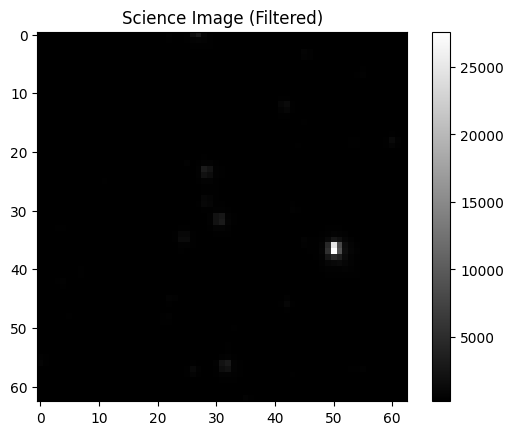

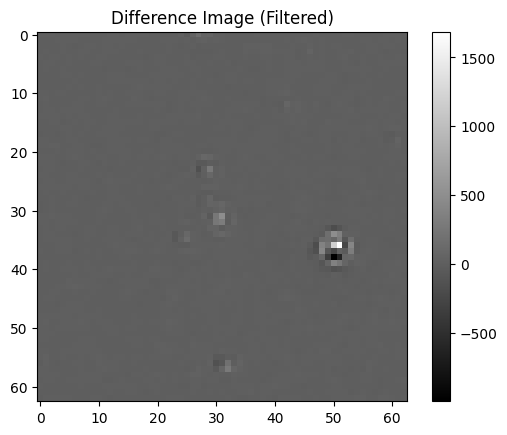

In [15]:
i = 1500
plt.imshow(all_alerts[i][0], cmap='gray')
plt.colorbar()
plt.title("Science Image (Filtered)")
plt.show()

plt.imshow(all_alerts[i][2], cmap='gray')
plt.colorbar()
plt.title("Difference Image (Filtered)")
plt.show()

In [12]:
# Normalizar Science
science_images = [cutouts[0] for cutouts in all_alerts]
science_images = np.array(science_images)
min_science = np.min(science_images)
max_science = np.max(science_images)
science_images_normalized = (science_images - min_science) / (max_science - min_science)

In [13]:
# Normalizar Template
template_images = [cutouts[1] for cutouts in all_alerts]
template_images = np.array(template_images)
min_template = np.min(template_images)
max_template = np.max(template_images)
template_images_normalized = (template_images - min_template) / (max_template - min_template)

In [14]:
# Normalizar Difference
difference_images = [cutouts[2] for cutouts in all_alerts]
difference_images = np.array(difference_images)
min_difference = np.min(difference_images)
max_difference = np.max(difference_images)
difference_images_normalized = 2 * (difference_images - min_difference) / (max_difference - min_difference) - 1

In [15]:
all_alerts = []
all_images_normalized = np.stack((science_images_normalized, template_images_normalized, difference_images_normalized), axis=-1)
science_images = []
science_images_normalized = []
template_images = []
template_images_normalized = []
difference_images = []
difference_images_normalized = []
all_images = []

In [16]:
train_images = []
test_images = []
train_images, test_images = train_test_split(all_images_normalized, test_size=0.2, random_state=42)
print(f"Forma de las imágenes de entrenamiento: {train_images[0].shape}")
all_images_normalized = []

Forma de las imágenes de entrenamiento: (63, 63, 3)


In [17]:
np.save('train_images.npy', train_images)
np.save('test_images.npy', test_images)

# Modelo

In [8]:
width = 63
train_images = np.load('train_images.npy')
test_images = np.load('test_images.npy')

In [5]:
import tensorflow as tf
# En caso de no poder usar GPU o necesitar desactivarla
tf.config.set_visible_devices([], 'GPU')
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout, BatchNormalization

2024-09-13 12:51:47.693438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 12:51:48.575619: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 12:51:48.825419: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-13 12:51:50.580608: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 12:51:57.563446: W tensorflow/compiler/tf2

In [6]:
print(train_images.dtype, train_images.shape)
print(test_images.dtype, test_images.shape)

float32 (43136, 63, 63, 3)
float32 (10784, 63, 63, 3)


In [22]:
# Modelo inicial
# Encoder
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

bottleneck = layers.Dense(encoding_dim, activation='relu')(encoded)

# Decoder
decoded = layers.Dense(32, activation='relu')(bottleneck)
decoded = layers.Dense(64, activation='relu')(decoded)
decoded = layers.Dense(128, activation='relu')(decoded)
output_img = layers.Dense(input_dim, activation='sigmoid')(decoded)


I0000 00:00:1726153686.435332   98339 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726153686.440798   98339 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726153686.443223   98339 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726153688.113975   98339 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [9]:
input_shape = (width, width, 3)
encoding_dim = 8

input_img = layers.Input(shape=input_shape)

# Encoder
encoded = layers.Flatten()(input_img)
encoded = layers.Dense(256)(encoded)
encoded = LeakyReLU(negative_slope=0.1)(encoded)
encoded = Dropout(0.5)(encoded)
encoded = BatchNormalization()(encoded)

encoded = layers.Dense(128)(encoded)
encoded = LeakyReLU(negative_slope=0.1)(encoded)
encoded = Dropout(0.5)(encoded)
encoded = BatchNormalization()(encoded)

encoded = layers.Dense(64)(encoded)
encoded = LeakyReLU(negative_slope=0.1)(encoded)
encoded = Dropout(0.5)(encoded)
encoded = BatchNormalization()(encoded)

bottleneck = layers.Dense(encoding_dim, activation='relu')(encoded)

# Decoder
decoded = layers.Dense(64, activation='relu')(bottleneck)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(256, activation='relu')(decoded)

decoded = layers.Dense(np.prod(input_shape), activation='sigmoid')(decoded)
output_img = layers.Reshape(input_shape)(decoded)

I0000 00:00:1726242799.799289   10960 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726242803.394794   10960 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726242803.398135   10960 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726242803.421096   10960 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [10]:
autoencoder = models.Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='mse')

from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min",
                                        patience=5,
                                        restore_best_weights=True)

history = autoencoder.fit(train_images, train_images, 
                          epochs=25, 
                          batch_size=32, 
                          shuffle=True, 
                          validation_data=(test_images, test_images),
                          callbacks=[earlystopping])

2024-09-13 12:53:33.553443: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2054481408 exceeds 10% of free system memory.
2024-09-13 12:53:35.572868: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2054481408 exceeds 10% of free system memory.
2024-09-13 12:53:46.626189: W external/local_tsl/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2054481408)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-09-13 12:53:46.626234: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-09-13 12:53:46.626252: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 26, Chunks in use: 26. 6.5KiB allocated for chunks. 6.5KiB in u

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [37]:
loss = autoencoder.evaluate(test_images, test_images)
print(f"Loss: {loss}")

337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0354
Loss: 0.03536203131079674


In [38]:
# Comparar Loss de ambos conjuntos para ver si hay sobreajuste
train_loss = autoencoder.evaluate(train_images, train_images, verbose=0)
print(f"Train Loss: {train_loss}")

test_loss = autoencoder.evaluate(test_images, test_images, verbose=0)
print(f"Test Loss: {test_loss}")

if test_loss > train_loss * 1.5:
    print("Posible sobreajuste detectado.")
else:
    print("El modelo generaliza bien.")


Train Loss: 0.03536286950111389
Test Loss: 0.03536203131079674
El modelo generaliza bien.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3276795..0.03956884].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32747668..0.0660184].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32775402..0.052913487].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3301825..0.068315536].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3318441..0.37060347].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3304916..0.3351972].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-

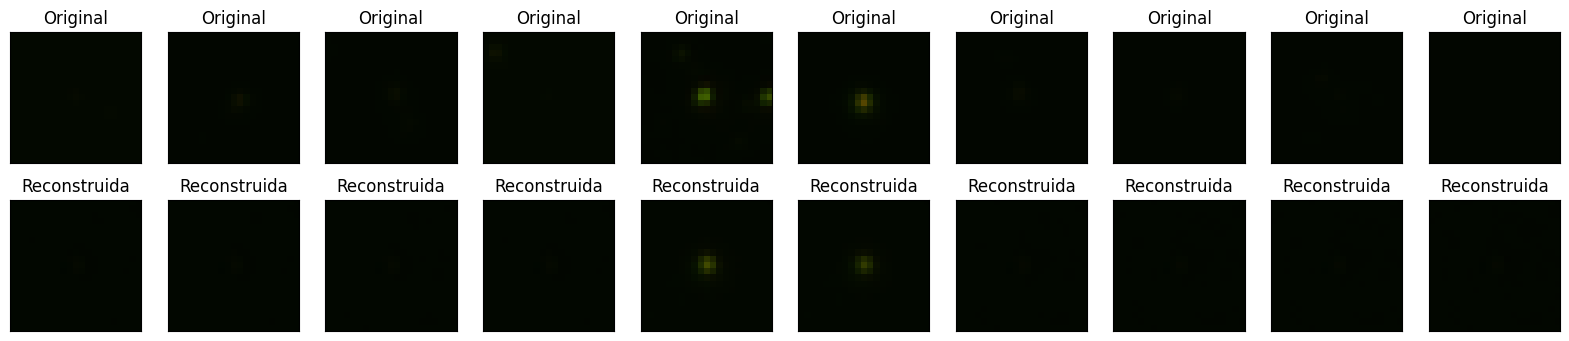

In [39]:
#Visualizar ejemplos de imágenes reconstruidas
n = 10
test_samples = test_images[:n]

reconstructed_images = autoencoder.predict(test_samples)

plt.figure(figsize=(20, 4))
for i in range(n):
    # Imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_samples[i].reshape(width, width, 3), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Original")
    
    # Imagen reconstruida
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].reshape(width, width, 3), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Reconstruida")
plt.show()